In [4]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import subprocess

import sys
from copy import copy
import scipy
import imageio
sys.path.append("../")
import itertools
from scipy.stats import norm
import matplotlib.mlab as mlab
from mvgavg import mvgavg
import json

save_folder = "G:/DREAM/from_github/thesis/Figures/LDA/"
import seaborn as sns

from random import randrange
from joblib import wrap_non_picklable_objects


from alienlab import utils
import alienlab
from alienlab import regression_func
import pickle as pk
from alienlab import plot
from activation_experiment import activation_experiment


import skimage.registration


from useful_func import dtw, get_path, plot_warped_timeseries
from useful_func import spectrum_a, spectrum_d
from useful_func import residuals, exp_decay, get_fit, sigmoid, exp_decay_max
from useful_func import gradient_magnitude, gradient_orientation, gaussian_kernel, assign_orientation, crop_center, cconv, get_algae_im
from numpy import genfromtxt

from joblib import Parallel, delayed
from useful_func import make_svm, make_pca
from sklearn.decomposition import PCA

from mpl_toolkits.axes_grid1 import make_axes_locatable



import sklearn
import sklearn.discriminant_analysis
import pandas as pd


import skimage

from useful_func import fit_biexp, fit_exp, fit_monoexp

import tifffile as tiff
import random
%matplotlib widget

g = plot.PlotFigure()
g.fontsize=17

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj][0]

def make_lda(n_components, train_data, Y_train_label):
    lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis(n_components = 3)
    M = train_data.mean(axis = 0)
    S = train_data.std(axis = 0)   
    train_data = (train_data - M)/S
    lda.fit(train_data,Y_train_label)
    X = lda.transform(train_data)
    print(X.shape)
    print("LDA components:")
    #lt.matshow(lda.scalings_)
    plt.figure()
    print("LDA explained variance:")
    plt.semilogy(lda.explained_variance_ratio_)
    plt.ylabel("eignevalue")
    plt.xlabel("component")

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:,2], c=Y_train_label)##
    #plt.plot(boundary[:,0], boundary[:,1], c = 'k')
    plt.xlabel("LD1")
    plt.ylabel("LD2")
    return lda, M, S


In [5]:
num_to_strain = {0: "STT7", 1: "WT4", 2: "CC124", 3: "WT222", 4: "NPQ4", 5:"CC125", 6:"STT71A6", 7: "WT4B", 8:"CC124_1h20", 9:"CC124_2h", 10: "WT222_2h"}
strain_to_num = {"STT7": 0, "WT4": 1, "CC124": 2, "WT222": 3, "NPQ4":4, "CC125":5, "STT71A6":6, "WT4B":7, "CC124_1h20":8, "CC124_2h":9, "WT222_2h":10}

def couple_list(list_pair):
    list_of_couples = list(zip(*list_pair))        

    diff  = np.array(len(list_of_couples[0])*["-"])
    A = np.array(list_of_couples[1]).astype(str)
    B = np.array(list_of_couples[0]).astype(str)   
    A = np.char.add(A, diff)
    couple_set = np.char.add(A, B)
    
    return list_of_couples, couple_set

def get_traces_from_couples(list_of_couples, traces):
    v0 = np.expand_dims(traces[:,250], 1)
    traces_0 = (v0 - traces[:,list_of_couples[0]])/traces[:,list_of_couples[0]]
    traces_1 = (v0 - traces[:,list_of_couples[1]])/traces[:,list_of_couples[1]]
    traces = traces_1 - traces_0
    return traces


def list_exps(folder, strain, lists_pair, nexp, start_id):


    content = []
    npq_list = []
    pulses_list = []
    actinic_list = []
    traces_list = []
    combine_dic = {}
    label_list = []
    exp_list = []
    algae_list = []
    mask_list = []
    imref_list = []
    id_list = []
    time_list = []
    
    for i in range(len(lists_pair)):
        combine_dic[i] = []
    
    
    for f in glob.glob(folder + "/*qE_calib*"):
        content.append(int(f.split("qE_calib_")[-1]))
    formexp = {}
    exp, num_exp = np.unique(content, return_counts=True)
    for i, e in enumerate(exp):
        formexp[e] = num_exp[i]-1
    for i in formexp.keys():
        elem = activation_experiment(folder)
        for j in range(formexp[i]+1):
            exps = elem.measure[i][j:j+1]
            exp_data = exps[0] + "/items_dict.npy"
            exp_data = np.load(exp_data, allow_pickle=True).item()
            mask = exp_data["labels"]
            imref = exp_data["im_ref"]
            time = exp_data["time"]
        
            fig = plt.figure()
            plt.axis("off")
            plt.imshow(mask)
            fig.tight_layout()
            plt.savefig('plotly_images/%d_%d_%d_mask.png'%(nexp, i, j))

            fig = plt.figure()
            plt.axis("off")
            plt.imshow(imref, cmap = 'Greys_r')
            fig.tight_layout()
            plt.savefig('plotly_images/%d_%d_%d_imref.png'%(nexp, i, j))

            plt.close('all')
            
            traces, labels, times = elem.get_traces_and_times(exps)
            if traces.shape[1]<2052:
                print("YOOO")
                pad = np.zeros((traces.shape[0], 2052 - traces.shape[1])) 
                traces = np.concatenate([traces, pad], axis = 1)
                times = np.concatenate([times, pad], axis = 1)
                time = np.concatenate([time, pad[0]])

            L =  len(traces[1])
            ints = np.linspace(0, L-1, L).astype(int)
            ints = ints[(ints-250)%20!=0]
            actinic = traces[:,ints]
            pulses = traces[:,250::20]
            npq = traces[:,250::20].T
            npq = (npq[0]- npq)/npq
            npq = npq.T
            for u, list_pair in enumerate(lists_pair):
                list_of_couples, couple_set = couple_list(list_pair)
                combine = get_traces_from_couples(list_of_couples, traces)
                combine_dic[u].append(combine)
                
            label = str(strain_to_num[strain]) + "_" + str(i) + "_" + str(j)

            npq_list.append(npq)
            pulses_list.append(pulses)#/pulses[:,0:1])
            actinic_list.append(actinic)#/actinic[:,250:251])
            traces_list.append(traces)#/traces[:,250:251])
            label_list.append([label]*len(combine))
            mask_list.append(mask)
            imref_list.append(imref)
            time_list.append(np.tile(time, (len(combine), 1)))
            exp_list.append([nexp]*len(combine))
            algae_list.append(list(range(len(combine))))
            id_list.append([start_id]*len(combine))
            start_id += 1
    print(folder)
            
    return npq_list, pulses_list, actinic_list, traces_list, label_list, exp_list, algae_list, id_list, time_list, mask_list, imref_list, start_id, combine_dic


In [6]:
list_pair4 = list(itertools.combinations([250, 270, 290, 1130, 1250, 1350, 1450, 1730, 2050], 2))

len(list_pair4)

36

In [7]:
folder_ref = "../"
list_pair0 = list(itertools.combinations(np.linspace(250, 2050, 91).astype(int), 2))
list_pair1 = list(itertools.combinations([250, 270, 290, 310, 330, 350, 370, 390, 410, 430, 450, 470, 490, 510, 1090, 1110,  1130, 1150, 1170, 1190, 1210, 1230, 1250, 1290, 2010, 2030, 2050], 2))
list_pair2 = list(itertools.combinations([250, 270, 290, 410, 1110,  1130, 1150, 1170, 2050], 2))
list_pair3 = list(itertools.combinations([250, 270, 350, 410, 550, 1110, 1150, 1170, 1250,1730], 2))
list_pair4 = [(250,270), (270,410), (250,410), (250, 1150), (1150, 1190), (250, 1730), (1190, 1730), (2050, 250)]
#list_pair4 = list(itertools.combinations([250, 270, 1110,  1130, 1150, 1170, 2050], 2))
#list_pair4 =  list(itertools.combinations([250, 270, 290, 410, 1110,  1130, 1150, 1170, 2050], 2))
#list_pair4 =  list(itertools.combinations([250, 270, 290, 310, 350, 390, 410, 1110,  1130, 1150, 1170, 2050], 2))
#list_pair3 =  list(itertools.combinations([250, 270, 290, 310, 410, 1110,  1130, 1150, 1170, 2050], 2))
#list_pair1 = list(itertools.combinations([250, 270, 290, 1110,  1130, 1150, 1170, 1250, 2050], 2))
#list_pair0 =  [(250,270), (1150, 1250), (1250, 1730), (2050, 250), (1730, 2050)]
#list_pair3 = list(itertools.combinations([250, 270, 290, 450, 1130, 1250, 1350, 1450, 1730, 2050], 2))
#list_pair4 = list(itertools.combinations([250, 270, 290, 1130, 1250, 1350, 1450, 1730, 2050], 2))

list_pair0 = [(250,270), (1250, 1730), (250, 2050)]#list(itertools.combinations(np.linspace(250, 2050, 91).astype(int), 2))
list_pair1 =  [(250,270), (1250, 1730), (250, 2050)]
list_pair2 = list(itertools.combinations([250, 270, 1130, 1250, 2050], 2))
list_pair3 = list(itertools.combinations([250, 270, 290, 450, 1130, 1250, 1350, 1450, 1730, 2050], 2))
list_pair4 = list(itertools.combinations([250, 270, 290, 1130, 1250, 1350, 1450, 1730, 2050], 2))


if True:
    folder_list = [("FOLDER_2022_03_10_activation_4H_ENS_stt7", "STT7"),
                   ("FOLDER_2022_03_08_activation_4H_ENS_wt4", "WT4"),
                   ("FOLDER_2022_03_09_activation_4H_ENS_npq4", "NPQ4"),
                   ("FOLDER_2022_03_16_WT222_SC1", "WT222"), 
                   ("FOLDER_2022_03_15_WT222_OLD", "WT222"),
                   ("FOLDER_2022_02_22_HL_chunks_WT4_backup", "WT4"),
                   ("FOLDER_2022_03_22_CC_124_activated_IBPC_sync", "CC124"),
                   ("FOLDER_2022_03_23_npq4_activated_IBPC_sync", "NPQ4"),
                   ("FOLDER_2022_03_24_stt71_activated_IBPC_sync", "STT7"),
                   ("FOLDER_2022_03_25_wt4_activated_IBPC_sync", "WT4"),
                   ("FOLDER_2022_03_31_STT71_polyculture_slow_activateion_45min", "STT7"), 
                   ("FOLDER_2022_04_07_stt71_scl3_monoclonal_synchro_ENS_4H", "STT7"),
                   ("FOLDER_2022_04_06_stt71_scl1_monoclonal_synchro_ENS_4H", "STT7"), 
                  ("FOLDER_2022_04_05_WT4_monoclonal_synchro_ENS_4H", "WT4"),
                  ("FOLDER_2022_03_30_4H_ENS_CC_124_sync", "CC124"), 
                  ("FOLDER_2022_03_29_4H_ENS_CC_124_sync", "CC124"), 
                    ("FOLDER_2022_02_16_WT4_non_induit_reduced", "WT4"),
                  #("FOLDER_2022_07_07_CC124_not_sync_2H", "CC124"), #some algae are chelou
                   ("FOLDER_2022_07_08_CC124_1_3h", "CC124_1h20"),
                  ("FOLDER_2022_10_07_CC125_Isabelle", "CC125"),
                  #("FOLDER_2022_10_11_stt71A6", "STT71A6"),
                  #("FOLDER_2022_10_13_WT222", "WT222"),
                  ("FOLDER_2022_11_23_stt71_A6_synchro_microbio_2H", "STT71A6"),
                   ("FOLDER_2022_11_23_wt4_synchro_microbio_2H", "WT4B"),
                   ("FOLDER_2022_12_07_wt4a_synchro_radio_2H", "WT4B"),
                   ("FOLDER_2022_12_07_wt4_continuous_2H", "WT4B"),
                   ("FOLDER_2022_12_08_stt71_A20_synchro_radio_2H", "STT7"),
                   ("FOLDER_2022_12_14_CC124_synchro_radio_2H", "CC124_2h"),
                   ("FOLDER_2022_12_15_WT222_synchro_radio_2H", "WT222_2h"),
                   ("FOLDER_2022_12_16_CC124_synchro_radio_1h20", "CC124_1h20"),
                   ("FOLDER_2022_12_17_WT222_synchro_radio_2H", "WT222_2h"), 
                   ("FOLDER_2022_12_21_CC124_synchro_radio_1h20", "CC124_1h20"),
                    ("FOLDER_2022_12_20_CC124_synchro_radio_2h", "CC124_2h"),
                   #("FOLDER_2023_01_10_wt4_synchro_sandrine1_2H", "WT4"),
                   #("FOLDER_2023_01_11_wt4_synchro_sandrine2_2H", "WT4"),
                   #("FOLDER_2023_01_12_wt4_synchro_sandrine3_2H", "WT4"),
                   #("FOLDER_2023_01_12_wt4_synchro_sandrine4_1H20", "WT4"),
                  ]



    npq_list = []
    pulses_list = []
    actinic_list = []
    traces_list = []
    label_list = []
    mask_list = []
    imref_list = []
    id_list = []
    time_list = []

    start_id=0



    combine0_list = []
    combine1_list = []
    combine2_list = []
    combine3_list = []
    combine4_list = []


    exp_list = []
    algae_list = []
    nexp = 0
    
    description_dic = {}
    
    
else: 
    list_list = ["label_list", "algae_list", "exp_list", "id_list", "time_list", 
         "pulses_list", "npq_list", 
         "actinic_list", "traces_list", 
         "combine0_list", "combine1_list", "combine2_list", "combine3_list", "combine4_list"]

    def get_list(name):
        arr = np.load("plotly_data/" + name + ".npy")
        liste = list(arr)
        return liste

    label_list = get_list("label_list")    
    algae_list = get_list("algae_list")
    exp_list = get_list("exp_list")
    id_list = get_list("id_list")
    time_list = get_list("time_list") 
    pulses_list = get_list("pulses_list") 
    npq_list = get_list("npq_list") 
    actinic_list = get_list("actinic_list") 
    traces_list = get_list("traces_list") 
    combine0_list = get_list("combine0_list")                   
    combine1_list = get_list("combine1_list") 
    combine2_list = get_list("combine2_list") 
    combine3_list = get_list("combine3_list") 
    combine4_list = get_list("combine4_list") 
    
    nexp = np.max(exp_list).astype(int) + 1
    start_id = np.max(id_list).astype(int)
    
    description_dic = json.load(open("plotly_data/"  + "class_match.json"))

    folder_list = []#("FOLDER_2022_10_13_WT222", "WT222")]
    

for folder, strain in folder_list:
    description_dic[nexp] = folder
    folder = folder_ref + folder
    npq, pulses, actinic, traces, label, num_exp, num_algae, idi, time, mask, imref, start_id, combine =  list_exps(folder, strain, [list_pair0, list_pair1, list_pair2, list_pair3, list_pair4], nexp, start_id)
    npq_list += npq
    pulses_list += pulses
    actinic_list += actinic
    traces_list += traces
    combine0_list += combine[0]
    combine1_list += combine[1]
    combine2_list += combine[2]
    combine3_list += combine[3]
    combine4_list += combine[4]

    label_list += label
    exp_list += num_exp
    algae_list += num_algae
    imref_list += imref
    mask_list += mask
    id_list += idi
    time_list += time
    nexp+=1


../FOLDER_2022_03_10_activation_4H_ENS_stt7
../FOLDER_2022_03_08_activation_4H_ENS_wt4
../FOLDER_2022_03_09_activation_4H_ENS_npq4
../FOLDER_2022_03_16_WT222_SC1
../FOLDER_2022_03_15_WT222_OLD
../FOLDER_2022_02_22_HL_chunks_WT4_backup
../FOLDER_2022_03_22_CC_124_activated_IBPC_sync
../FOLDER_2022_03_23_npq4_activated_IBPC_sync
../FOLDER_2022_03_24_stt71_activated_IBPC_sync
../FOLDER_2022_03_25_wt4_activated_IBPC_sync
../FOLDER_2022_03_31_STT71_polyculture_slow_activateion_45min
../FOLDER_2022_04_07_stt71_scl3_monoclonal_synchro_ENS_4H
../FOLDER_2022_04_06_stt71_scl1_monoclonal_synchro_ENS_4H
../FOLDER_2022_04_05_WT4_monoclonal_synchro_ENS_4H
../FOLDER_2022_03_30_4H_ENS_CC_124_sync
../FOLDER_2022_03_29_4H_ENS_CC_124_sync
../FOLDER_2022_02_16_WT4_non_induit_reduced
../FOLDER_2022_07_08_CC124_1_3h
../FOLDER_2022_10_07_CC125_Isabelle
../FOLDER_2022_11_23_stt71_A6_synchro_microbio_2H
../FOLDER_2022_11_23_wt4_synchro_microbio_2H
../FOLDER_2022_12_07_wt4a_synchro_radio_2H
../FOLDER_2022_12_07

In [8]:
elem = activation_experiment(folder)
elem.measure[0]

['../FOLDER_2022_12_20_CC124_synchro_radio_2h\\2022-12-20_12_39_qE_calib_0',
 '../FOLDER_2022_12_20_CC124_synchro_radio_2h\\2022-12-20_13_16_qE_calib_0',
 '../FOLDER_2022_12_20_CC124_synchro_radio_2h\\2022-12-20_13_52_qE_calib_0',
 '../FOLDER_2022_12_20_CC124_synchro_radio_2h\\2022-12-20_14_29_qE_calib_0']

In [9]:

list_list = [label_list, algae_list, exp_list, id_list, time_list, 
             pulses_list, npq_list, 
             actinic_list, traces_list, 
             combine0_list, combine1_list, combine2_list, combine3_list, combine4_list]
"""
for i in range(len(list_list)):
    name  = namestr(list_list[i], globals())
    list_list[i] = np.array(list_list[i])
"""

'\nfor i in range(len(list_list)):\n    name  = namestr(list_list[i], globals())\n    list_list[i] = np.array(list_list[i])\n'

In [10]:

for i in range(len(list_list)):
    name  = namestr(list_list[i], globals())
    list_list[i] = np.array(np.concatenate(list_list[i], axis =0))
    np.save("plotly_data/" + name + ".npy", list_list[i])

imref_array = np.array(imref_list)
np.save("plotly_data/imref_list.npy", imref_array)

mask_array = np.array(mask_list)
np.save("plotly_data/mask_list.npy", mask_array)

In [11]:
label_array, algae_array, exp_array, id_array, time_array, pulses_array, npq_array, actinic_array, traces_array, combine0_array, combine1_array, combine2_array, combine3_array,  combine4_array = list_list

In [12]:
npq_array[npq_array != npq_array] = 0
npq_array[npq_array == np.inf] = 0

In [13]:
v = "0_0_0"
corresp_id = np.unique(id_array[label_array==v])
for ind in corresp_id: 
    print(exp_array[id_array==ind][0])

0
10
11
12
23


In [14]:
class_match = {}
for k in range(np.unique(id_array).max()+1):
    u = exp_array[id_array==k][0]
    
    class_match[k] = description_dic[u]
    

with open('plotly_data/class_match.json', 'w') as fp:
    json.dump(class_match, fp)    
    
    
    
with open('plotly_data/description_match.json', 'w') as fp:
    json.dump(description_dic, fp)    

In [15]:
description_dic

{0: 'FOLDER_2022_03_10_activation_4H_ENS_stt7',
 1: 'FOLDER_2022_03_08_activation_4H_ENS_wt4',
 2: 'FOLDER_2022_03_09_activation_4H_ENS_npq4',
 3: 'FOLDER_2022_03_16_WT222_SC1',
 4: 'FOLDER_2022_03_15_WT222_OLD',
 5: 'FOLDER_2022_02_22_HL_chunks_WT4_backup',
 6: 'FOLDER_2022_03_22_CC_124_activated_IBPC_sync',
 7: 'FOLDER_2022_03_23_npq4_activated_IBPC_sync',
 8: 'FOLDER_2022_03_24_stt71_activated_IBPC_sync',
 9: 'FOLDER_2022_03_25_wt4_activated_IBPC_sync',
 10: 'FOLDER_2022_03_31_STT71_polyculture_slow_activateion_45min',
 11: 'FOLDER_2022_04_07_stt71_scl3_monoclonal_synchro_ENS_4H',
 12: 'FOLDER_2022_04_06_stt71_scl1_monoclonal_synchro_ENS_4H',
 13: 'FOLDER_2022_04_05_WT4_monoclonal_synchro_ENS_4H',
 14: 'FOLDER_2022_03_30_4H_ENS_CC_124_sync',
 15: 'FOLDER_2022_03_29_4H_ENS_CC_124_sync',
 16: 'FOLDER_2022_02_16_WT4_non_induit_reduced',
 17: 'FOLDER_2022_07_08_CC124_1_3h',
 18: 'FOLDER_2022_10_07_CC125_Isabelle',
 19: 'FOLDER_2022_11_23_stt71_A6_synchro_microbio_2H',
 20: 'FOLDER_2022_

In [16]:
for K in range(300):
    print(K, description_dic[exp_array[id_array==K][0]], label_array[id_array==K][0])


0 FOLDER_2022_03_10_activation_4H_ENS_stt7 0_0_0
1 FOLDER_2022_03_10_activation_4H_ENS_stt7 0_0_1
2 FOLDER_2022_03_10_activation_4H_ENS_stt7 0_0_2
3 FOLDER_2022_03_10_activation_4H_ENS_stt7 0_0_3
4 FOLDER_2022_03_10_activation_4H_ENS_stt7 0_1_0
5 FOLDER_2022_03_10_activation_4H_ENS_stt7 0_1_1
6 FOLDER_2022_03_10_activation_4H_ENS_stt7 0_1_2
7 FOLDER_2022_03_10_activation_4H_ENS_stt7 0_1_3
8 FOLDER_2022_03_10_activation_4H_ENS_stt7 0_2_0
9 FOLDER_2022_03_10_activation_4H_ENS_stt7 0_2_1
10 FOLDER_2022_03_10_activation_4H_ENS_stt7 0_2_2
11 FOLDER_2022_03_10_activation_4H_ENS_stt7 0_2_3
12 FOLDER_2022_03_08_activation_4H_ENS_wt4 1_0_0
13 FOLDER_2022_03_08_activation_4H_ENS_wt4 1_0_1
14 FOLDER_2022_03_08_activation_4H_ENS_wt4 1_0_2
15 FOLDER_2022_03_08_activation_4H_ENS_wt4 1_0_3
16 FOLDER_2022_03_08_activation_4H_ENS_wt4 1_1_0
17 FOLDER_2022_03_08_activation_4H_ENS_wt4 1_1_1
18 FOLDER_2022_03_08_activation_4H_ENS_wt4 1_1_2
19 FOLDER_2022_03_08_activation_4H_ENS_wt4 1_1_3
20 FOLDER_2022_03_

In [17]:
def generate_col(): #colormap
    colors = plt.cm.nipy_spectral(np.linspace(0,1,3000))
    random.seed(4)
    random.shuffle(colors)
    return colors
generate_col()

array([[0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       ...,
       [0.09411176, 0.        , 0.65492941, 1.        ],
       [0.        , 0.64577451, 0.3659902 , 1.        ],
       [0.        , 0.62877255, 0.78042549, 1.        ]])

## identify references

In [18]:
selected_labels = np.copy(id_array)*0

## STT7 no exposure

[  0 162 182 198 354]


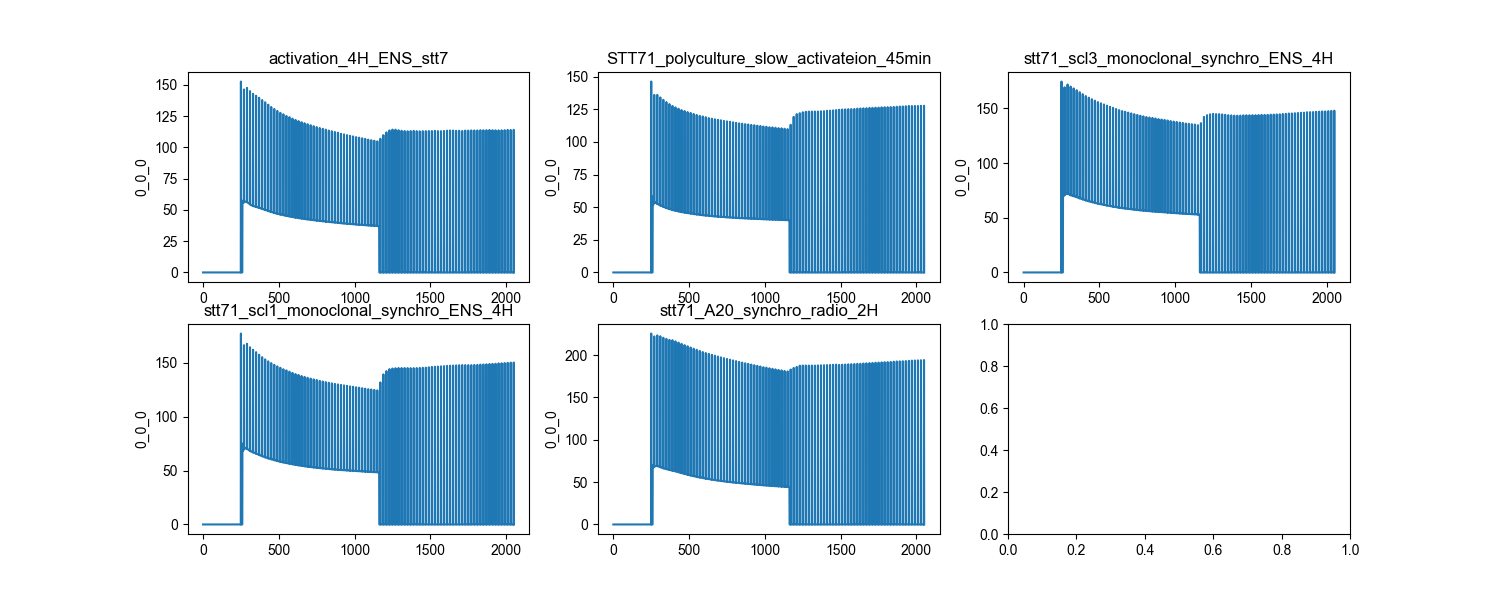

In [19]:
val = id_array[label_array=="0_0_0"]
possible_set = np.unique(val)
print(possible_set)
fig, axs = plt.subplots((len(possible_set)-1)//3+1,3, figsize=(15,6))
axs = axs.flatten()
for i, ind in enumerate(possible_set):
    idx = id_array==ind
    axs[i].plot(np.mean(traces_array[idx], axis=0))
    axs[i].set_title(description_dic[exp_array[idx][0]][18:])
    axs[i].set_ylabel(label_array[idx][0])
    selected_labels[idx] = 1
    


## WT4 no exposure

[ 12  55 218 249]


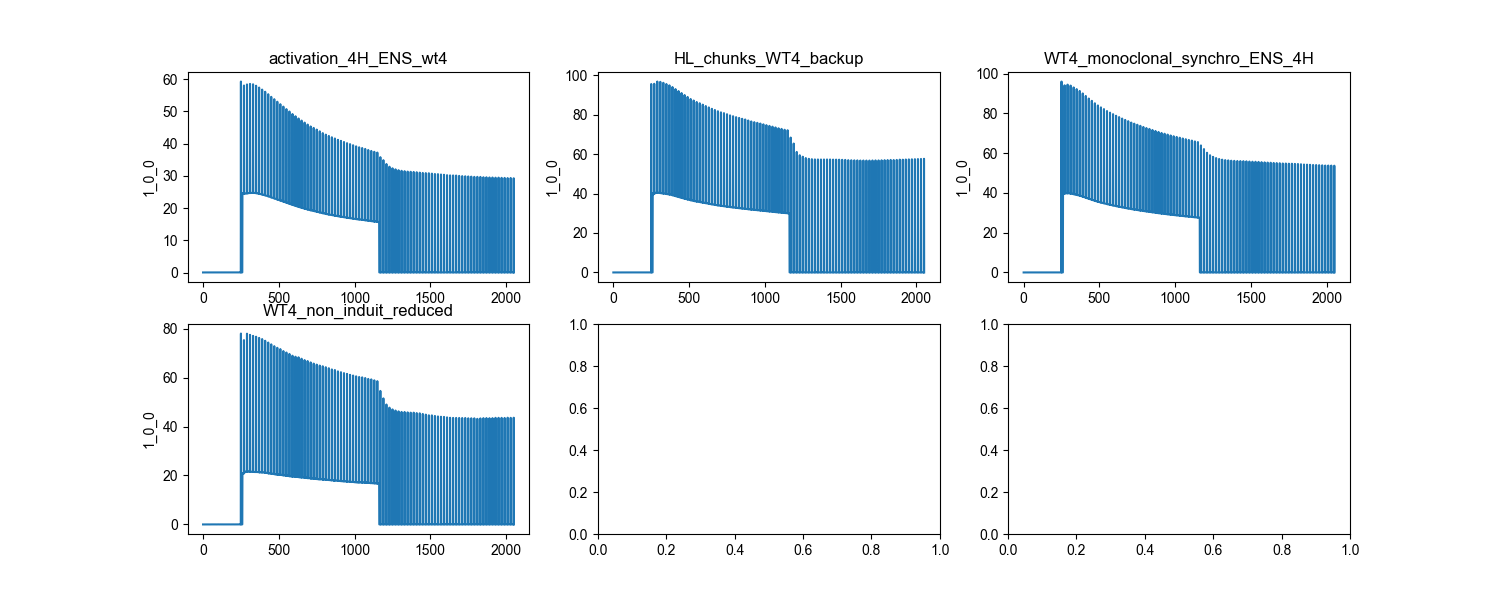

In [20]:
val = id_array[label_array=="1_0_0"]
possible_set = np.unique(val)
print(possible_set)
fig, axs = plt.subplots((len(possible_set)-1)//3+1,3, figsize=(15,6))
axs = axs.flatten()
for i, ind in enumerate(possible_set):
    idx = id_array==ind
    axs[i].plot(np.mean(traces_array[idx], axis=0))
    axs[i].set_title(description_dic[exp_array[idx][0]][18:])
    axs[i].set_ylabel(label_array[idx][0])
    #selected_labels[idx] = 1
    


# STT7 photoinhibited

In [21]:
possible_set = np.unique(val)


[  2 164 184 200 356]


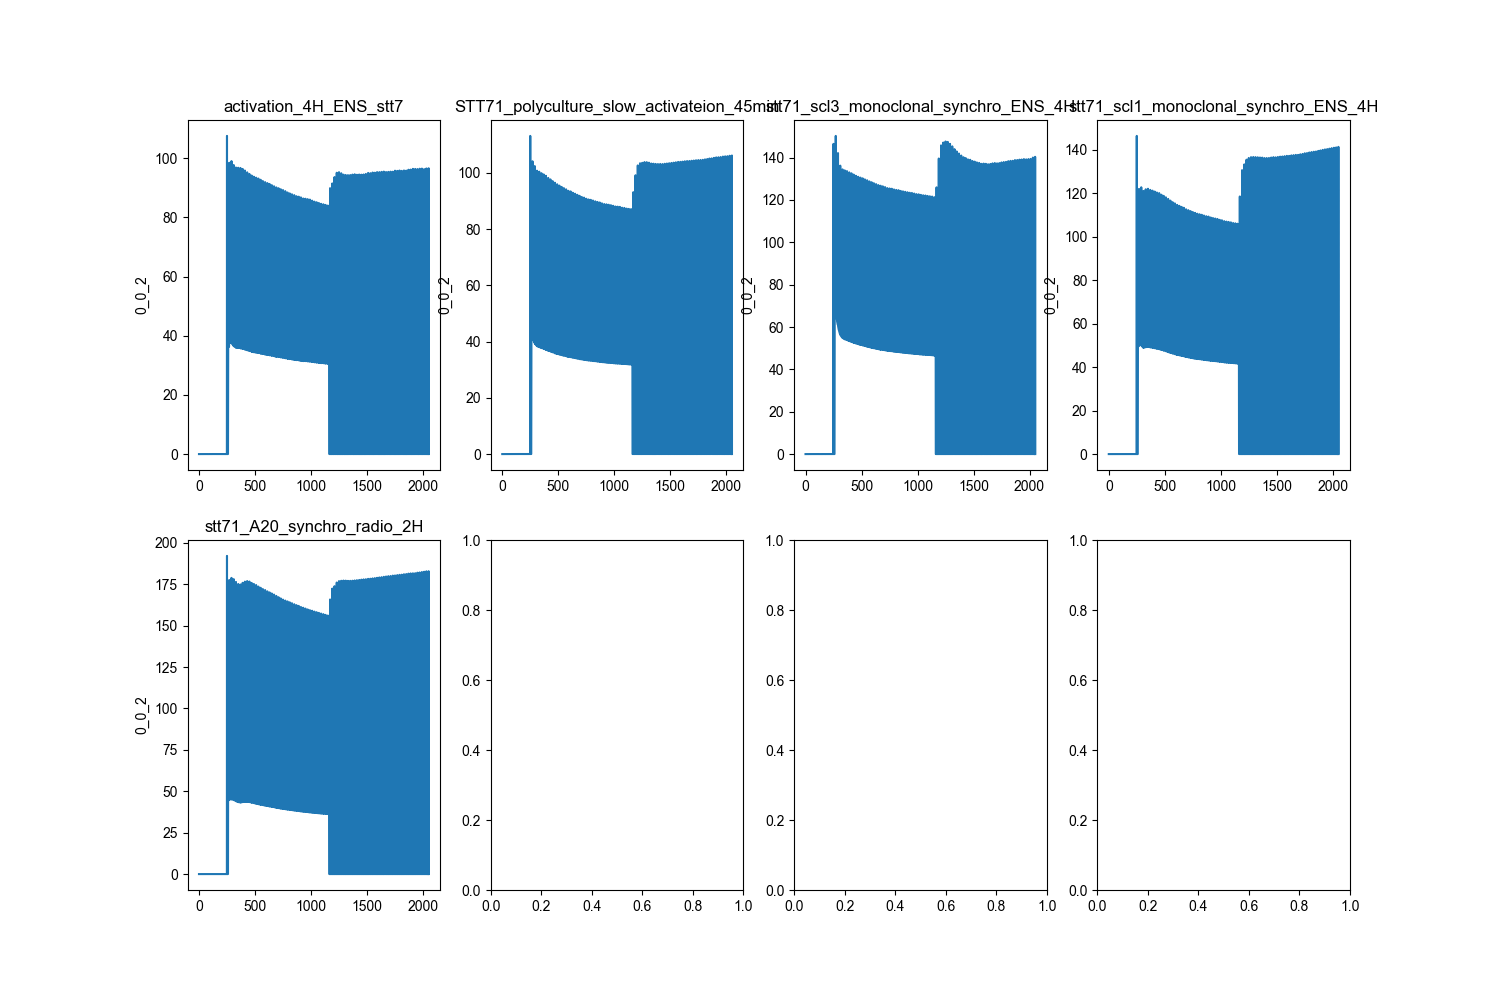

In [22]:
val = id_array[(label_array=="0_0_2")]# + (label_array=="0_0_2")]
possible_set = np.unique(val)
print(possible_set)
#possible_set = [1, 450, 163]
#possible_set = [1, 2, 367]
#possible_set = [2, 164, 367]

fig, axs = plt.subplots((len(possible_set)-1)//4+1,4, figsize=(15,10))
axs = axs.flatten()
for i, ind in enumerate(possible_set):
    idx = id_array==ind
    axs[i].plot(np.mean(traces_array[idx], axis=0))
    axs[i].set_title(description_dic[exp_array[idx][0]][18:])
    axs[i].set_ylabel(label_array[idx][0])
    selected_labels[idx] = 2

## SST7 activated

[  7 121 169 189 205 361]


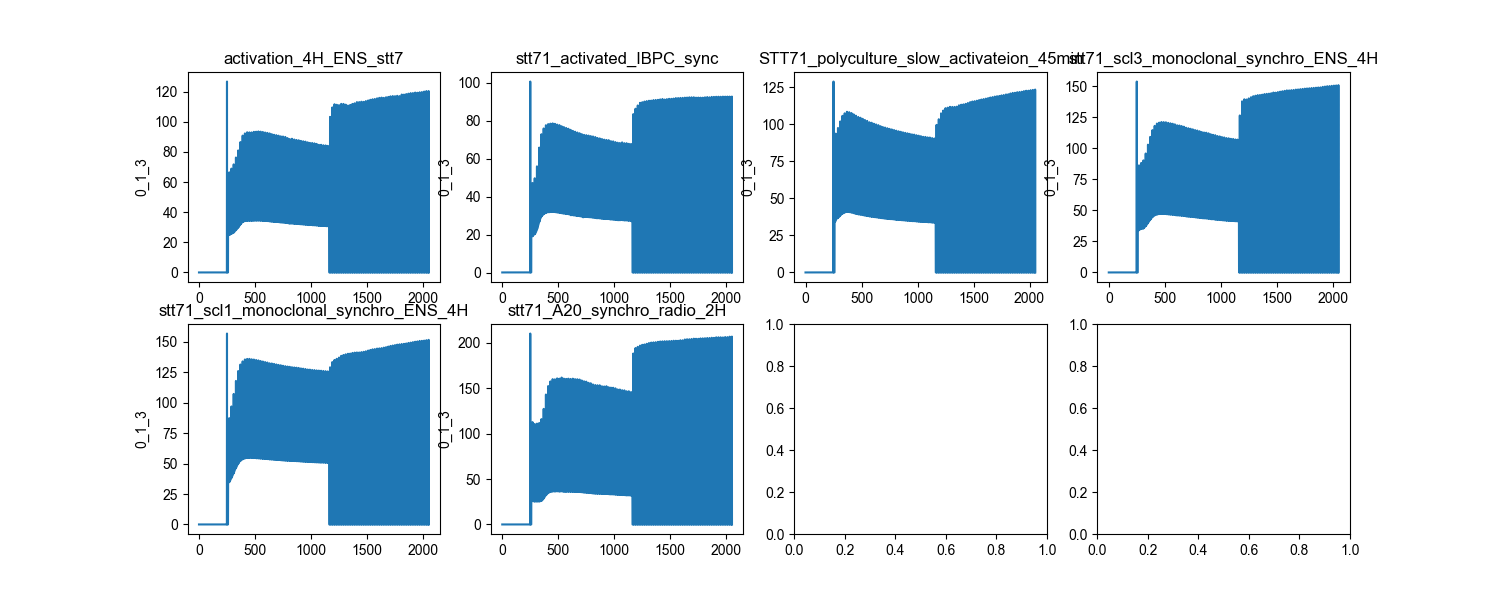

In [23]:

val = id_array[(label_array=="0_1_3")]#(label_array=="0-1-2")+
possible_set = np.unique(val)
print(possible_set)
fig, axs = plt.subplots((len(possible_set)-1)//4+1,4, figsize=(15,6))
axs = axs.flatten()
for i, ind in enumerate(possible_set):
    idx = id_array==ind
    axs[i].plot(np.mean(traces_array[idx], axis=0))
    axs[i].set_title(description_dic[exp_array[idx][0]][18:])
    axs[i].set_ylabel(label_array[idx][0])
    selected_labels[idx] = 3

## WT not activated

In [24]:
possible_set

array([  7, 121, 169, 189, 205, 361])

[ 14  15  57 220 221 251 252 256 257 379 380 409 410 432 433 448 449]
14
15
57
220
221
251
252
256
257
379
380
409
410
432
433
448
449


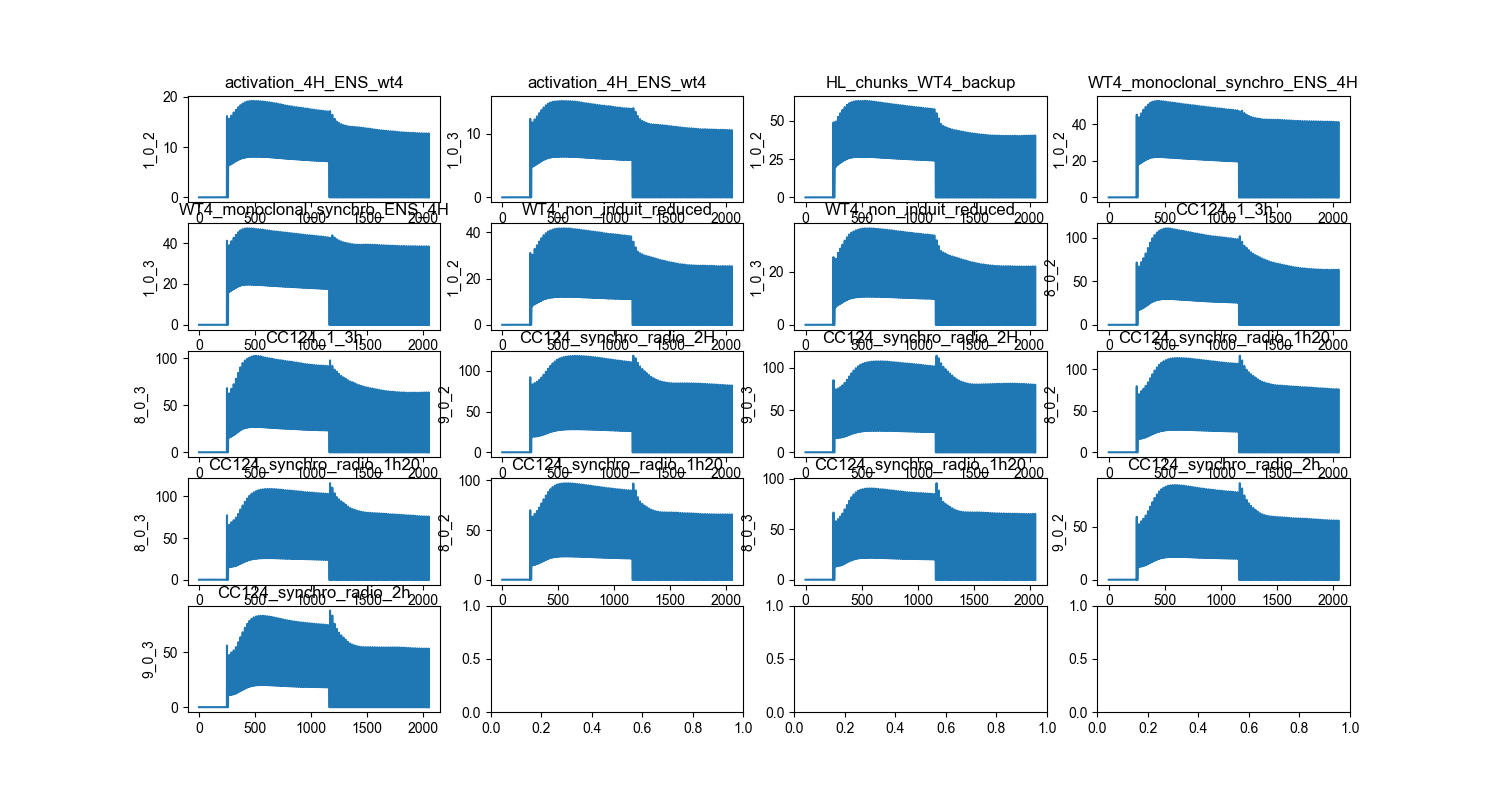

In [25]:

val = id_array[(label_array=="1_0_3") + (label_array=="1_0_2") +(label_array=="8_0_3") + (label_array=="8_0_2") + (label_array=="9_0_3") + (label_array=="9_0_2")]
possible_set = np.unique(val)
print(possible_set)
#possible_set = [14,  15, 28, 229,238 ,239, 251, 252 ,256]#, 475, 476, 486, 487, 498, 499]
fig, axs = plt.subplots((len(possible_set)-1)//4+1,4, figsize=(15,8))
axs = axs.flatten()
for i, ind in enumerate(possible_set):
    print(ind)
    idx = id_array==ind
    axs[i].plot(np.mean(traces_array[idx], axis=0))
    axs[i].set_title(description_dic[exp_array[idx][0]][18:])
    axs[i].set_ylabel(label_array[idx][0])
    selected_labels[idx] = 4

## WT4 activated

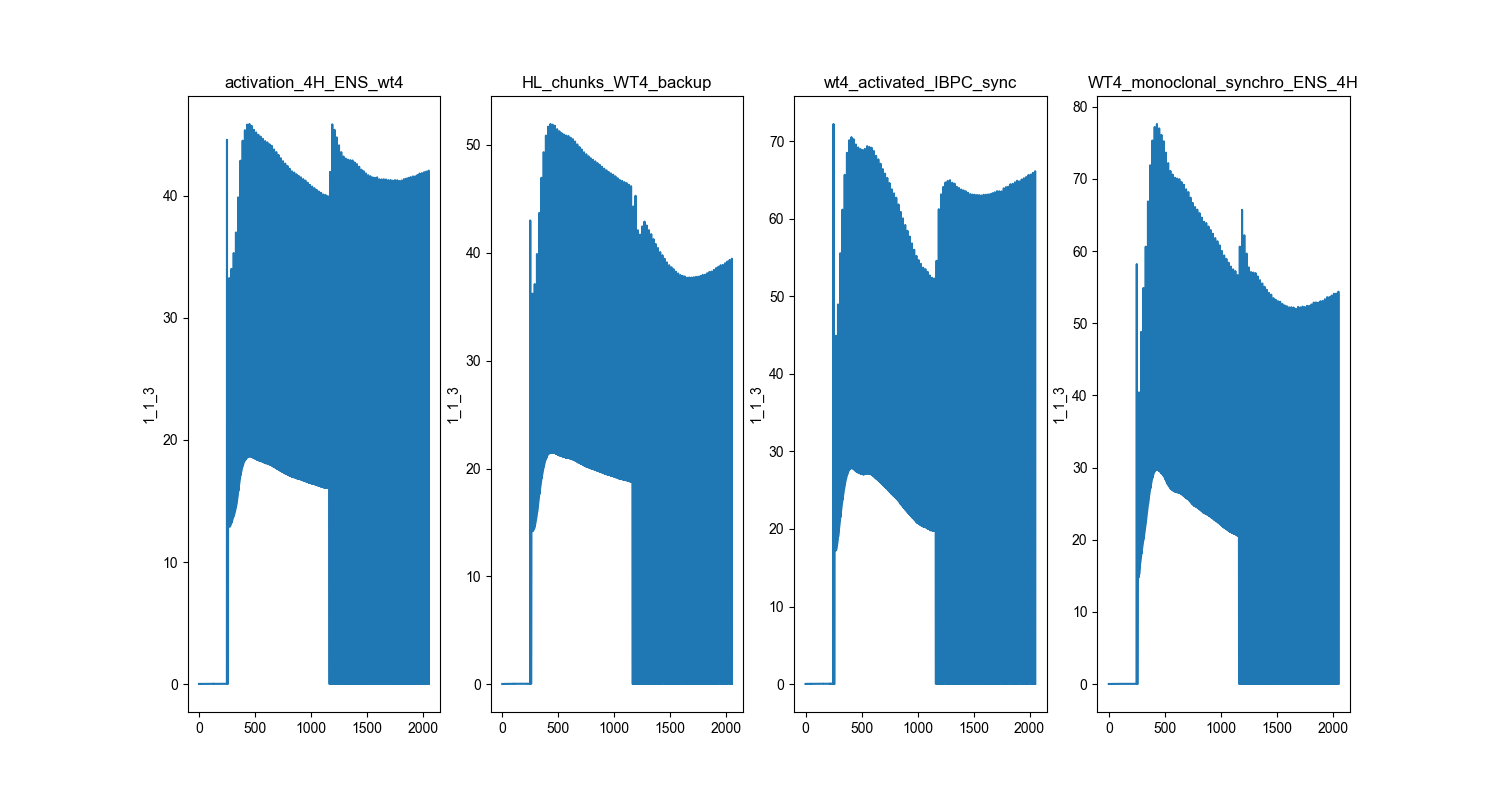

In [26]:

val = id_array[(label_array=="1_1_3")]#+(label_array=="2-0-3") +(label_array=="3-0-3")]#+  (label_array=="1-0-2")+(label_array=="2-0-2")(label_array=="3-0-2")]
possible_set = np.unique(val)
possible_set = possible_set[0:4]
fig, axs = plt.subplots((len(possible_set)-1)//4+1,4, figsize=(15,8))
axs = axs.flatten()
for i, ind in enumerate(possible_set):
    idx = id_array==ind
    axs[i].plot(np.mean(traces_array[idx], axis=0))
    axs[i].set_title(description_dic[exp_array[idx][0]][18:])
    axs[i].set_ylabel(label_array[idx][0])
    selected_labels[idx] = 5

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


train size : (7399, 3)
validation size : (75, 3)
test size : (76, 3)
(7399, 3)
LDA components:
LDA explained variance:


'\nM_svm = np.mean(train_set, axis = 0)\nS_svm = np.std(train_set, axis = 0)\ntrain_svm = (train_set - M_svm)/S_svm\nvalidation_svm = (validation_set - M_svm)/S_svm\nfinal_model = make_svm(train_svm, train_classes)\n\n\npred = final_model.predict(validation_svm)\nprint("validation accuracy:", np.mean(pred==validation_classes))\nplt.show()\n'

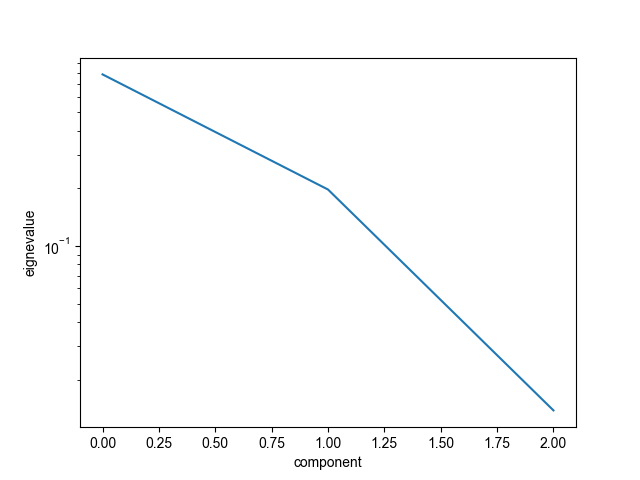

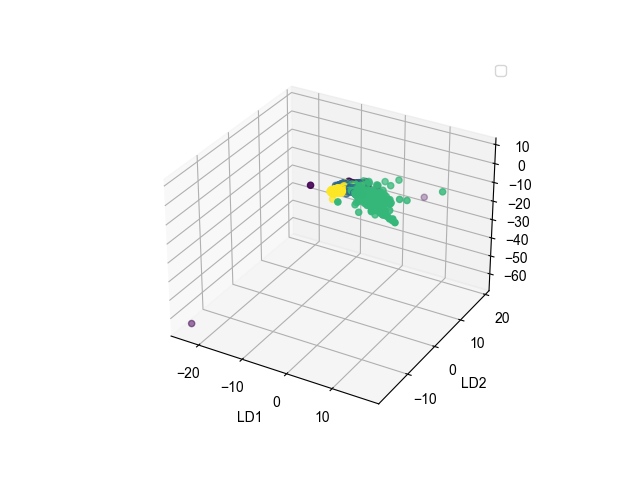

In [27]:
idx = (selected_labels == 4)+(selected_labels == 1)+(selected_labels == 2)+(selected_labels == 3)

DATA = combine1_array
data = np.copy(DATA[idx])
all_data = np.copy(DATA)
indices = np.array(list(range(data.shape[0])))
train, test, train_indices, test_indices = sklearn.model_selection.train_test_split(data, indices, test_size = 0.01)#, random_state = 1) #always generate the same test set
train, validation, train_indices, validation_indices = sklearn.model_selection.train_test_split(train, train_indices, test_size = 0.01)
print("train size :", train.shape)
print("validation size :", validation.shape)
print("test size :", test.shape)


train_set = train
validation_set = validation
train_classes = selected_labels[idx][train_indices]
validation_classes= selected_labels[idx][validation_indices]
#train_set = (train_set - train_set.mean())/train_set.std()

lda, M_lda, S_lda = make_lda(train.shape[1], train_set, train_classes)
pk.dump(lda, open("lda.pkl","wb"))




#fig = plt.figure()
#ax = fig.add_subplot(projection='3d')
mean_pos = []
for label in np.unique(train_classes):
    ind = train_classes == label
    X = lda.transform((train_set[ind]- M_lda)/S_lda)
    mean_pos.append(np.mean(X[:,:3], axis = 0))
#    ax.scatter(X[:, 0], X[:, 1], X[:,2])##

plt.legend()
"""
M_svm = np.mean(train_set, axis = 0)
S_svm = np.std(train_set, axis = 0)
train_svm = (train_set - M_svm)/S_svm
validation_svm = (validation_set - M_svm)/S_svm
final_model = make_svm(train_svm, train_classes)


pred = final_model.predict(validation_svm)
print("validation accuracy:", np.mean(pred==validation_classes))
plt.show()
"""



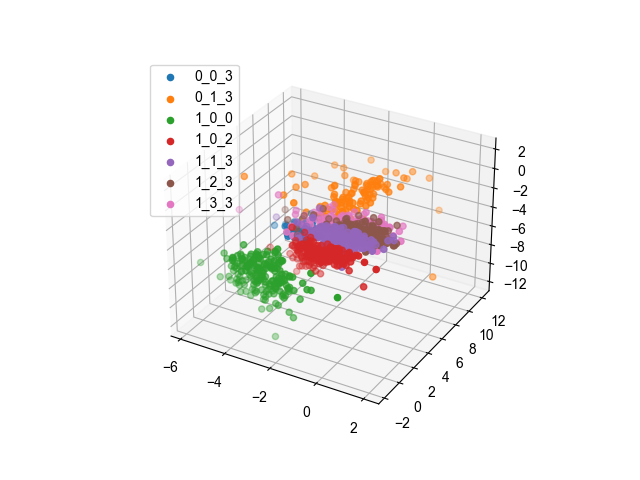

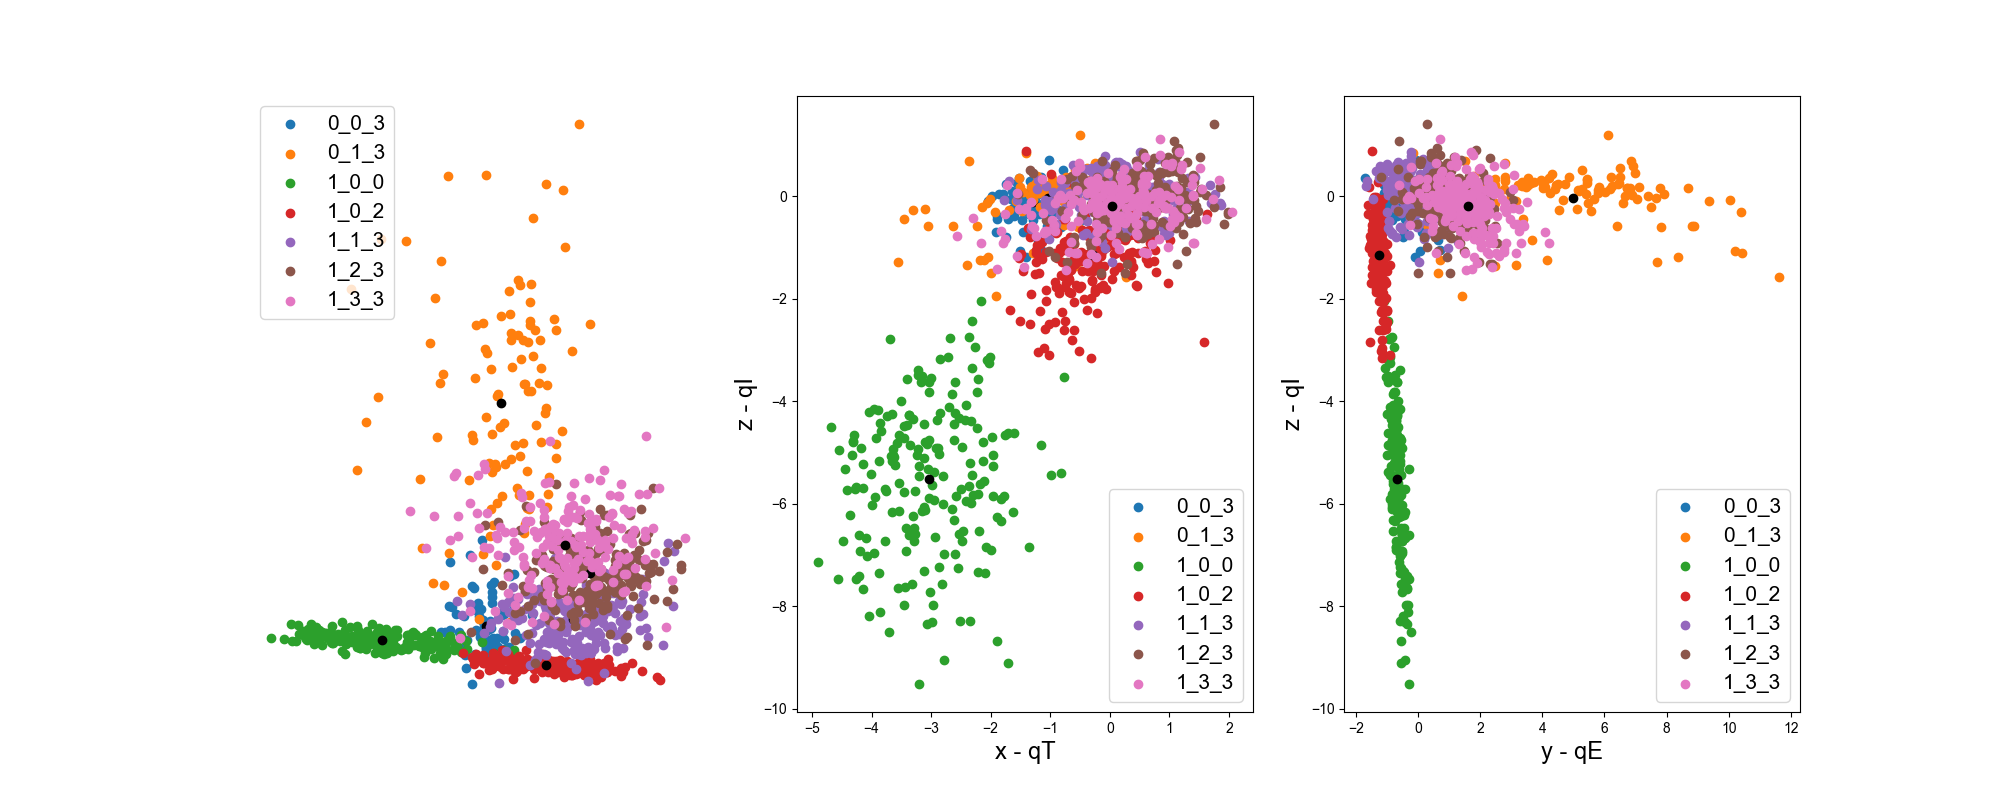

In [28]:
ax0 = mean_pos[3] - mean_pos[1]
ax1 = mean_pos[2] - mean_pos[1]
ax0 = ax0/np.linalg.norm(ax0)
ax1 = ax1/np.linalg.norm(ax1)
ax2 = np.cross(ax0, ax1)

B = np.array([ax0, ax1, ax2]).T

R = np.linalg.inv(B)

Tr = lda.scalings_[:,:3]
RTr= np.dot(R, Tr.T)

def transform_data(data, transform):
    #print(data.shape, transform.shape)
    data = (data.T - M_lda)/S_lda
    XT = np.dot(data, transform.T)
    
    return XT



np.savetxt("M_lda.csv",M_lda)
np.savetxt("S_lda.csv",S_lda)
np.savetxt("RTr.csv", RTr)

    
selected_classes = [3, 7, 55, 57, 61, 65, 69]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig2, ax2 = plt.subplots(1, 3, figsize = (20, 8))

XT =  transform_data(all_data.T, RTr)

lower_bounds = np.quantile(XT, 0.019, axis = 0)
upper_bounds = np.quantile(XT, 0.99, axis = 0)


for label in selected_classes:
    ind = id_array == label
    X = XT[ind]
    description = label_array[ind][0]

    ax.scatter(X[:, 0], X[:, 1], X[:,2], label = description)##
    select = abs(X - np.mean(X, axis = 0)) < 3 * np.std(X, axis = 0)
    select = select.min(axis = 1)

    ax2[0].scatter(X[select,0], X[select,1], label = description)
    ax2[0].scatter(np.mean(X[select,0]), np.mean(X[select,1]), color = "k")

    ax2[0].set_xlabel('x - qT', fontsize=17)
    ax2[0].set_ylabel('y - qE', fontsize=17)

    #ax2[0].set_xlim(lower_bounds[0], upper_bounds[0])
    #ax2[0].set_ylim(lower_bounds[1], upper_bounds[1])

    ax2[1].scatter(X[select,0], X[select,2], label = description)
    ax2[1].scatter(np.mean(X[select,0]), np.mean(X[select,2]), color = "k")

    ax2[1].set_xlabel('x - qT', fontsize=17)
    ax2[1].set_ylabel('z - qI', fontsize=17)
    #ax2[1].set_xlim(lower_bounds[0], upper_bounds[0])
    #ax2[1].set_ylim(lower_bounds[2], upper_bounds[2])

    ax2[2].scatter(X[select,1], X[select,2], label = description)
    ax2[2].scatter(np.mean(X[select,1]), np.mean(X[select,2]), color = "k")

    ax2[2].set_xlabel('y - qE', fontsize=17)
    ax2[2].set_ylabel('z - qI', fontsize=17)
    #ax2[2].set_xlim(lower_bounds[1], upper_bounds[1])
    #ax2[2].set_ylim(lower_bounds[2], upper_bounds[2])

ax.legend()
ax2[0].legend(prop = {"size": 15})
ax2[0].axis("off")
ax2[1].legend(prop = {"size": 15})
ax2[2].legend(prop = {"size": 15})


In [29]:

p = [1e6]
for i in range(1, 5):
    S = np.sum(selected_labels == i)
    print(S)
    p.append(S)
p = np.array(p)

idx = np.copy(selected_labels)*0
np.random.seed(4)
for i in range(1,5):
    idx += (selected_labels == i)*(np.random.rand(len(idx))<=np.min(p)/p[i])
idx = idx.astype(bool)

795
772
975
5008


## Simple array base ref

-0.26532941739185106 0.5341928014161641 -0.011138252484188794 1.7943838135682315


TypeError: list indices must be integers or slices, not str

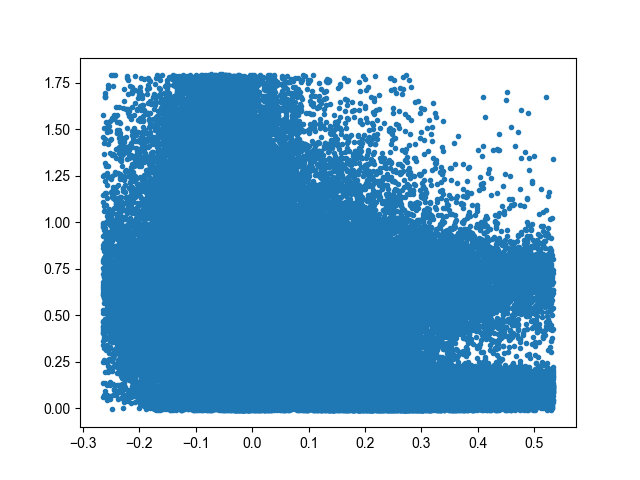

In [30]:

def NPQ(P, F0, F1):
    return (P[:,F0] - P[:,F1])/P[:,F1] 

P =  pulses_array
qE= NPQ(P, 0, 1)
qT = NPQ(P, 48,90)
qI = NPQ(P, 0, 90)

array = np.stack([qT, qE, qI]).T

name = "simple_array"
np.save("plotly_data/%s_proj.npy"%name,  array)

lims = []
from function_figures import clip_xy
for couple in [(0,1), (0,2), (1,2)]:
    Xl,Yl = clip_xy(array[:,couple[0]], array[:,couple[1]])
    plt.figure()
    plt.plot(Xl, Yl, '.')

    lims["%d,%d"%couple] = [plt.gca().get_xlim(), plt.gca().get_ylim()]
    plt.close("all")
with open('plotly_data/%s_ax_lim.json'%name, 'w') as fp:
    json.dump(lims, fp)    

## dico learning

In [35]:
train_pulses = pulses_array[idx]
train_pulses = train_pulses/train_pulses[:,0:1]
M_lda = train_pulses.mean()
S_lda = train_pulses.std()
train_pulses = (train_pulses - M_lda)/S_lda
print(train_pulses.shape)

(3080, 91)


In [36]:
from sklearn.decomposition import MiniBatchDictionaryLearning
dict_learner = MiniBatchDictionaryLearning(
     n_components=15, transform_algorithm='lasso_lars', transform_alpha=0.05,
    random_state=42, n_jobs = -1, verbose = 0)
X_transform = dict_learner.fit_transform(train_pulses)
dict_array = dict_learner.transform(pulses_array)

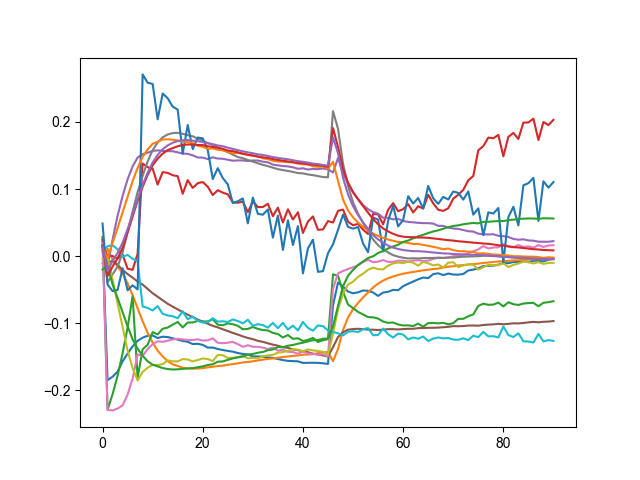

In [37]:
plt.figure()
for i in range(15):
    plt.plot(dict_learner.components_[i])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


dict_array
train size : (3018, 15)
validation size : (31, 15)
test size : (31, 15)
(3018, 3)
LDA components:
LDA explained variance:
all_data (136300, 15)
RTr (3, 15)


C:\Users\Alienor\AppData\Local\Temp\ipykernel_6252\3565518482.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig2, ax2 = plt.subplots(1, 3, figsize = (20, 8))


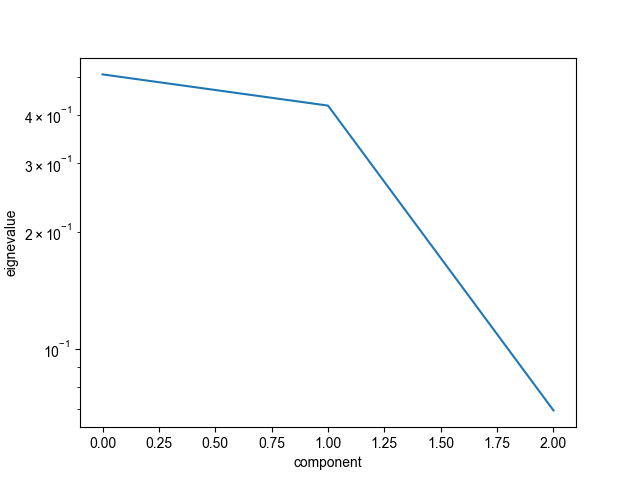

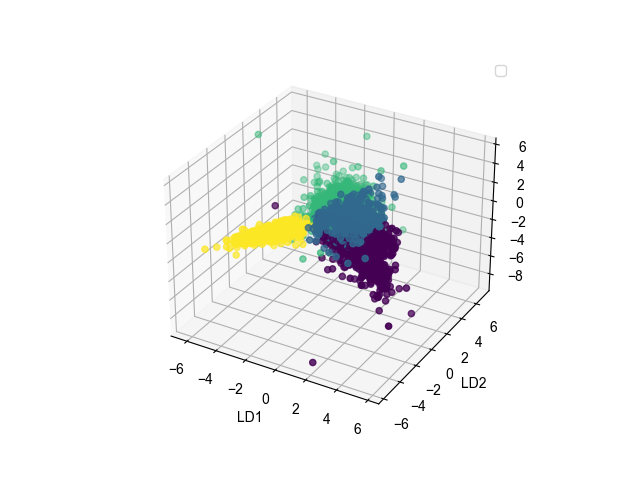

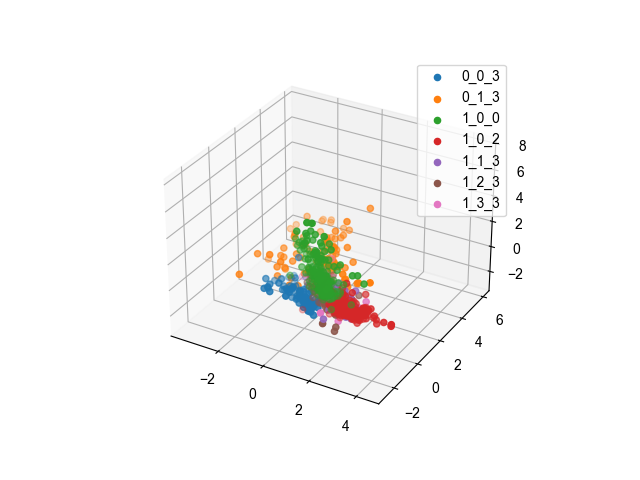

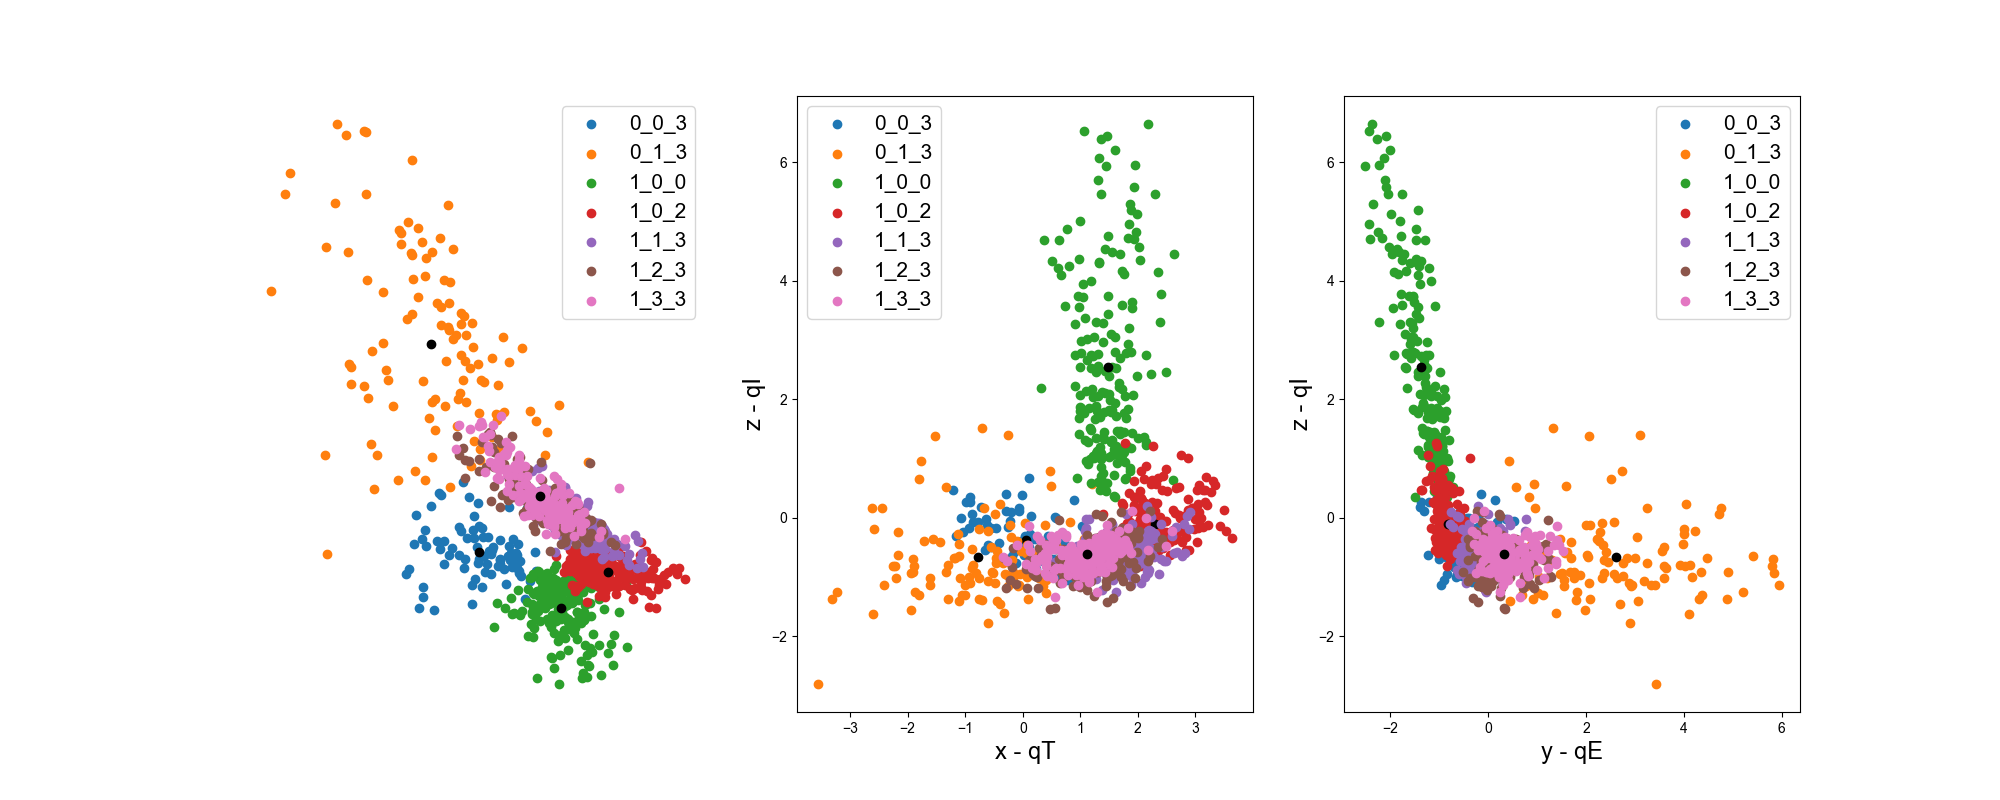

In [38]:

features = [dict_array]#, combine1_array, combine2_array, combine3_array, combine4_array,combine0_array, pulses_array, actinic_array, traces_array, npq_array,  ]

for u in range(len(features)):
    name = namestr(features[u], globals())
    print(name)
    DATA = features[u]
    #idx = (selected_labels == 4)+ (selected_labels == 3) + (selected_labels == 2) + (selected_labels == 1)
    data = np.copy(DATA[idx])
    all_data = np.copy(DATA)
    indices = np.array(list(range(data.shape[0])))
    train, test, train_indices, test_indices = sklearn.model_selection.train_test_split(data, indices, test_size = 0.01)#, random_state = 1) #always generate the same test set
    train, validation, train_indices, validation_indices = sklearn.model_selection.train_test_split(train, train_indices, test_size = 0.01)
    print("train size :", train.shape)
    print("validation size :", validation.shape)
    print("test size :", test.shape)


    train_set = train
    validation_set = validation
    train_classes = selected_labels[idx][train_indices]
    validation_classes= selected_labels[idx][validation_indices]
    #train_set = (train_set - train_set.mean())/train_set.std()

    lda, M_lda, S_lda = make_lda(train.shape[1], train_set, train_classes)
    pk.dump(lda, open("plotly_data/%s_lda.pkl"%name,"wb"))




    #fig = plt.figure()
    #ax = fig.add_subplot(projection='3d')
    mean_pos = []
    for label in np.unique(train_classes):
        ind = train_classes == label
        X = lda.transform((train_set[ind]- M_lda)/S_lda)
        mean_pos.append(np.mean(X[:,:3], axis = 0))
    #    ax.scatter(X[:, 0], X[:, 1], X[:,2])##

    plt.legend()


    ax0 = mean_pos[3] - mean_pos[1]
    ax1 = mean_pos[2] - mean_pos[1]
    ax0 = ax0/np.linalg.norm(ax0)
    ax1 = ax1/np.linalg.norm(ax1)
    ax2 = np.cross(ax0, ax1)

    B = np.array([ax0, ax1, ax2]).T

    R = np.linalg.inv(B)

    Tr = lda.scalings_[:,:3]
    RTr= np.dot(R, Tr.T)

    def transform_data(data, transform):
        #print(data.shape, transform.shape)
        data = (data.T - M_lda)/S_lda

        XT = np.dot(data, transform.T)


        return XT

    np.savetxt("plotly_data/%s_M_lda.csv"%name,M_lda)
    np.savetxt("plotly_data/%s_S_lda.csv"%name,S_lda)
    np.savetxt("plotly_data/%s_RTr.csv"%name, RTr)


    selected_classes = [3, 7, 55, 57, 61, 65, 69]

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    fig2, ax2 = plt.subplots(1, 3, figsize = (20, 8))
    print("all_data", all_data.shape)
    print('RTr', RTr.shape)
    XT =  transform_data(all_data.T, RTr)
    np.save("plotly_data/%s_proj.npy"%name, XT)

    lower_bounds = np.quantile(XT, 0.019, axis = 0)
    upper_bounds = np.quantile(XT, 0.99, axis = 0)

    lims = {}
    for label in selected_classes:
        ind = id_array == label
        X = XT[ind]
        description = label_array[ind][0]

        ax.scatter(X[:, 0], X[:, 1], X[:,2], label = description)##
        select = abs(X - np.mean(X, axis = 0)) < 3 * np.std(X, axis = 0)
        select = select.min(axis = 1)

        ax2[0].scatter(X[select,0], X[select,1], label = description)
        ax2[0].scatter(np.mean(X[select,0]), np.mean(X[select,1]), color = "k")

        ax2[0].set_xlabel('x - qT', fontsize=17)
        ax2[0].set_ylabel('y - qE', fontsize=17)
        lims01x = ax2[0].get_xlim()
        lims01y = ax2[0].get_ylim()

        #ax2[0].set_xlim(lower_bounds[0], upper_bounds[0])
        #ax2[0].set_ylim(lower_bounds[1], upper_bounds[1])

        ax2[1].scatter(X[select,0], X[select,2], label = description)
        ax2[1].scatter(np.mean(X[select,0]), np.mean(X[select,2]), color = "k")

        ax2[1].set_xlabel('x - qT', fontsize=17)
        ax2[1].set_ylabel('z - qI', fontsize=17)
        lims02x = ax2[1].get_xlim()
        lims02y = ax2[1].get_ylim()
        #ax2[1].set_xlim(lower_bounds[0], upper_bounds[0])
        #ax2[1].set_ylim(lower_bounds[2], upper_bounds[2])

        ax2[2].scatter(X[select,1], X[select,2], label = description)
        ax2[2].scatter(np.mean(X[select,1]), np.mean(X[select,2]), color = "k")

        ax2[2].set_xlabel('y - qE', fontsize=17)
        ax2[2].set_ylabel('z - qI', fontsize=17)
        lims12x = ax2[2].get_xlim()
        lims12y = ax2[2].get_ylim()
        #ax2[2].set_xlim(lower_bounds[1], upper_bounds[1])
        #ax2[2].set_ylim(lower_bounds[2], upper_bounds[2])

    ax.legend()
    ax2[0].legend(prop = {"size": 15})
    ax2[0].axis("off")
    ax2[1].legend(prop = {"size": 15})
    ax2[2].legend(prop = {"size": 15})

    lims["0,1"] = [lims01x, lims01y]
    lims["0,2"] = [lims02x, lims02y]
    lims["1,2"] = [lims12x, lims12y]
    
    with open('plotly_data/%s_ax_lim.json'%name, 'w') as fp:
        json.dump(lims, fp)    
    

In [ ]:
RTr.shape

##### lims0x

In [ ]:
X = np.load("plotly_data/combine0_array_proj.npy")


ind = id_array==221
T = traces_array[ind]
plt.figure()

for i in range(200):
    #plt.plot(T[i])
    plt.scatter(X[i,0], X[i,1])

In [ ]:
len(features)

In [ ]:
combine4_array.shape

In [ ]:
lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis(n_components = 3)
M = train_data.mean(axis = 0)
S = train_data.std(axis = 0)   
train_data = (train_data - M)/S
lda.fit(train_data,Y_train_label)
X = lda.transform(train_data)
print(train_data.shape)
X.shape

In [ ]:
train_data = np.copy(train)

In [ ]:

train_set = train
validation_set = validation
train_classes = selected_labels[idx][train_indices]

In [ ]:
train_data = np.copy(train_set)
Y_train_label = np.copy(train_classes)

In [ ]:
S_lda

In [ ]:
all_data.shape

In [ ]:
npq_array[npq_array!=npq_array] = 0

In [ ]:
npq_array[npq_array==np.inf] = 0

In [ ]:
plt.figure()
a = plt.hist(npq_array.flatten())

In [ ]:
plt.figure()
plt.plot(pulses_array[10, :])

In [ ]:
plt.figure()
plt.plot(actinic_array[10, :])
plt.plot(250, actinic_array[10, 250], 'o')

In [ ]:
plt.figure()
plt.plot(traces_array[10, :])
plt.plot(250, traces_array[10, 250], 'o')

In [ ]:
plt.figure()
plt.plot(combine0_array[10, :])